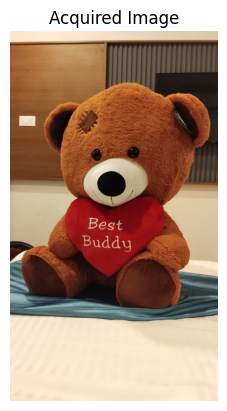

In [4]:
import cv2
import matplotlib.pyplot as plt

# Change this to your file name
filename = "teddy.jpg"

# Read the image
img = cv2.imread(filename)

# Convert BGR (OpenCV default) to RGB (for matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show the image
plt.imshow(img_rgb)
plt.title("Acquired Image")
plt.axis("off")
plt.show()


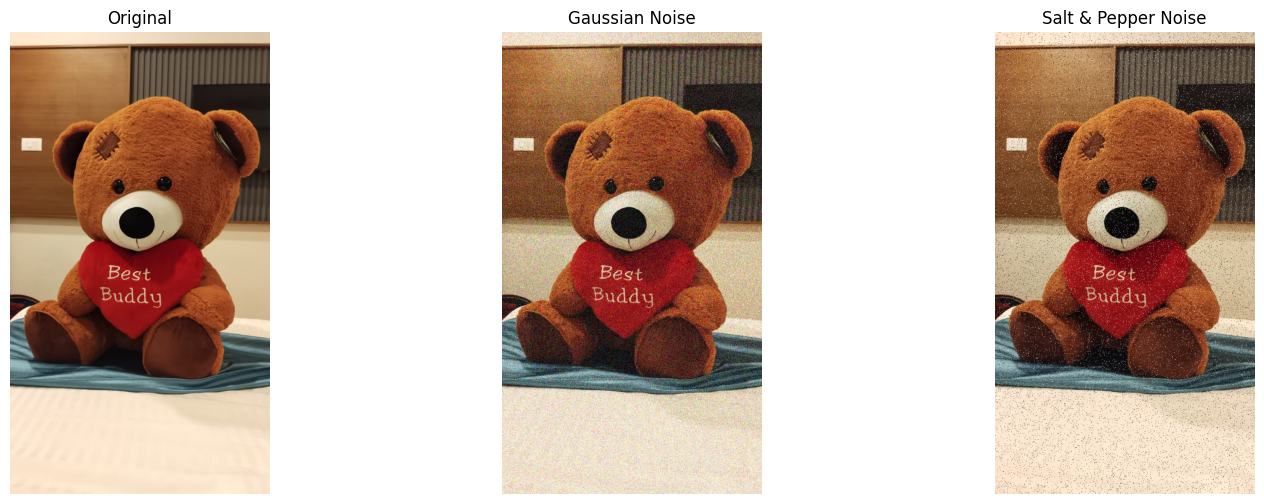

In [11]:
# --- Noise Simulation (Gaussian and Salt & Pepper) ---

import numpy as np
import matplotlib.pyplot as plt

# Convert image to float in [0,1]
img_float = img_rgb.astype(np.float32) / 255.0

# Gaussian noise
def add_gaussian_noise(image):
    sigma = 0.15  # adjust intensity of noise
    gauss = np.random.normal(0, sigma, image.shape)
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 1)
    return noisy

gaussian_img = add_gaussian_noise(img_float)

# Salt & Pepper noise
def add_salt_pepper_noise(image):
    prob = 0.05
    noisy = np.copy(image)
    rnd = np.random.rand(*image.shape[:2])
    noisy[rnd < (prob/2)] = 0.0       # Pepper (black)
    noisy[rnd > 1 - (prob/2)] = 1.0   # Salt (white)
    return noisy

sp_img = add_salt_pepper_noise(img_float)

# Show results
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gaussian_img)
plt.title("Gaussian Noise")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(sp_img)
plt.title("Salt & Pepper Noise")
plt.axis("off")

plt.show()


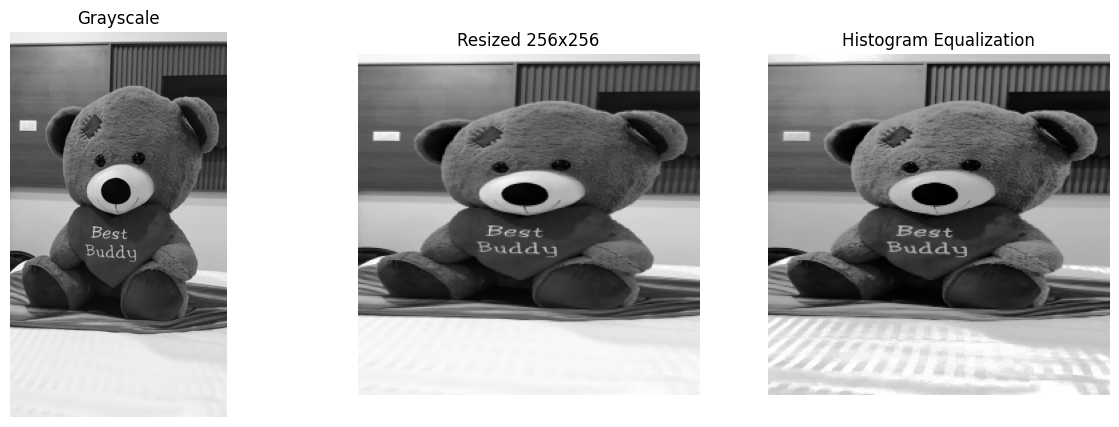

In [4]:
# --- Preprocessing & Enhancement ---

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Resize to 256x256
gray_resized = cv2.resize(gray, (256, 256), interpolation=cv2.INTER_AREA)

# Histogram Equalization
hist_eq = cv2.equalizeHist(gray_resized)

# Show results
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gray_resized, cmap='gray')
plt.title("Resized 256x256")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(hist_eq, cmap='gray')
plt.title("Histogram Equalization")
plt.axis("off")

plt.show()


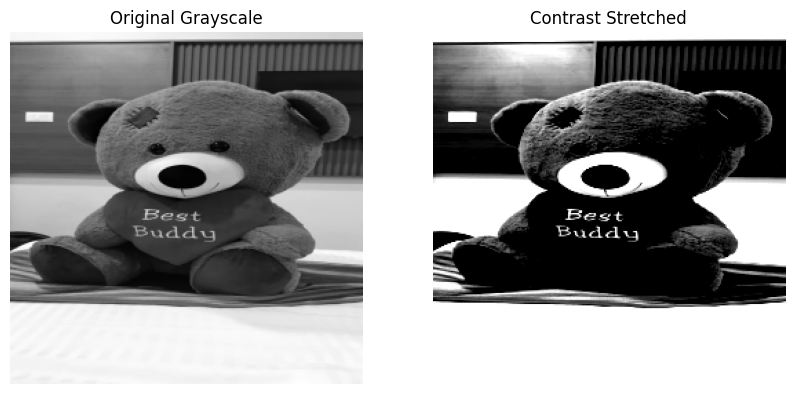

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function for manual contrast stretching with chosen limits
def contrast_stretching(img, r1=70, r2=180, s1=0, s2=255):
    img = img.astype(np.float32)
    stretched = np.zeros_like(img)

    # Apply piecewise linear transformation
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] < r1:
                stretched[i, j] = (s1 / r1) * img[i, j]
            elif img[i, j] < r2:
                stretched[i, j] = ((s2 - s1) / (r2 - r1)) * (img[i, j] - r1) + s1
            else:
                stretched[i, j] = ((255 - s2) / (255 - r2)) * (img[i, j] - r2) + s2

    return stretched.astype(np.uint8)

# Apply with chosen thresholds
contrast_img = contrast_stretching(gray_resized, r1=80, r2=160)

# Display before vs after
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_resized, cmap='gray')
plt.title("Original Grayscale")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(contrast_img, cmap='gray')
plt.title("Contrast Stretched")
plt.axis("off")
plt.show()


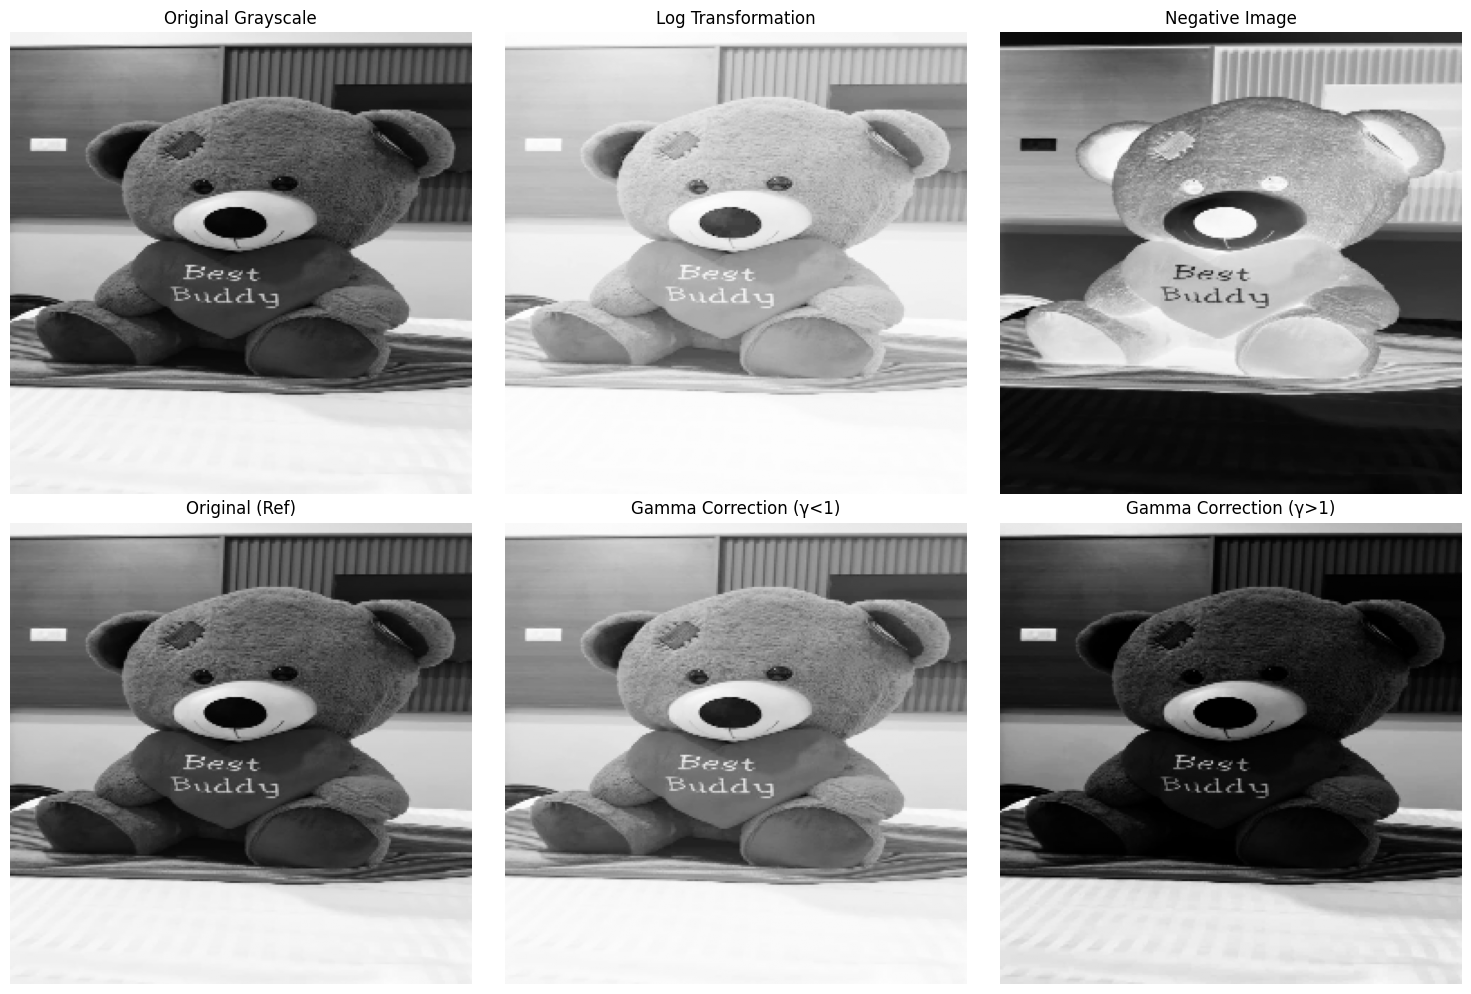

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Grayscale image (resized for uniformity)
gray_resized = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (256, 256))

# Log Transformation
c = 255 / np.log(1 + np.max(gray_resized))
log_img = (c * np.log(1 + gray_resized)).astype(np.uint8)

# Negative Transformation
neg_img = 255 - gray_resized

# Gamma Correction
def gamma_correction(img, gamma=1.5):
    img = img / 255.0
    corrected = np.power(img, gamma)
    corrected = np.uint8(corrected * 255)
    return corrected

gamma_bright = gamma_correction(gray_resized, gamma=0.5)  # brighten
gamma_dark = gamma_correction(gray_resized, gamma=2.0)    # darken

# Show results
fig, axs = plt.subplots(2, 3, figsize=(15,10))

axs[0,0].imshow(gray_resized, cmap='gray')
axs[0,0].set_title("Original Grayscale"); axs[0,0].axis("off")

axs[0,1].imshow(log_img, cmap='gray')
axs[0,1].set_title("Log Transformation"); axs[0,1].axis("off")

axs[0,2].imshow(neg_img, cmap='gray')
axs[0,2].set_title("Negative Image"); axs[0,2].axis("off")

axs[1,0].imshow(gray_resized, cmap='gray')
axs[1,0].set_title("Original (Ref)"); axs[1,0].axis("off")

axs[1,1].imshow(gamma_bright, cmap='gray')
axs[1,1].set_title("Gamma Correction (γ<1)"); axs[1,1].axis("off")

axs[1,2].imshow(gamma_dark, cmap='gray')
axs[1,2].set_title("Gamma Correction (γ>1)"); axs[1,2].axis("off")

plt.tight_layout()
plt.show()


Median Filter - PSNR: 28.76  SSIM: 0.892
Gaussian Filter - PSNR: 26.2  SSIM: 0.788


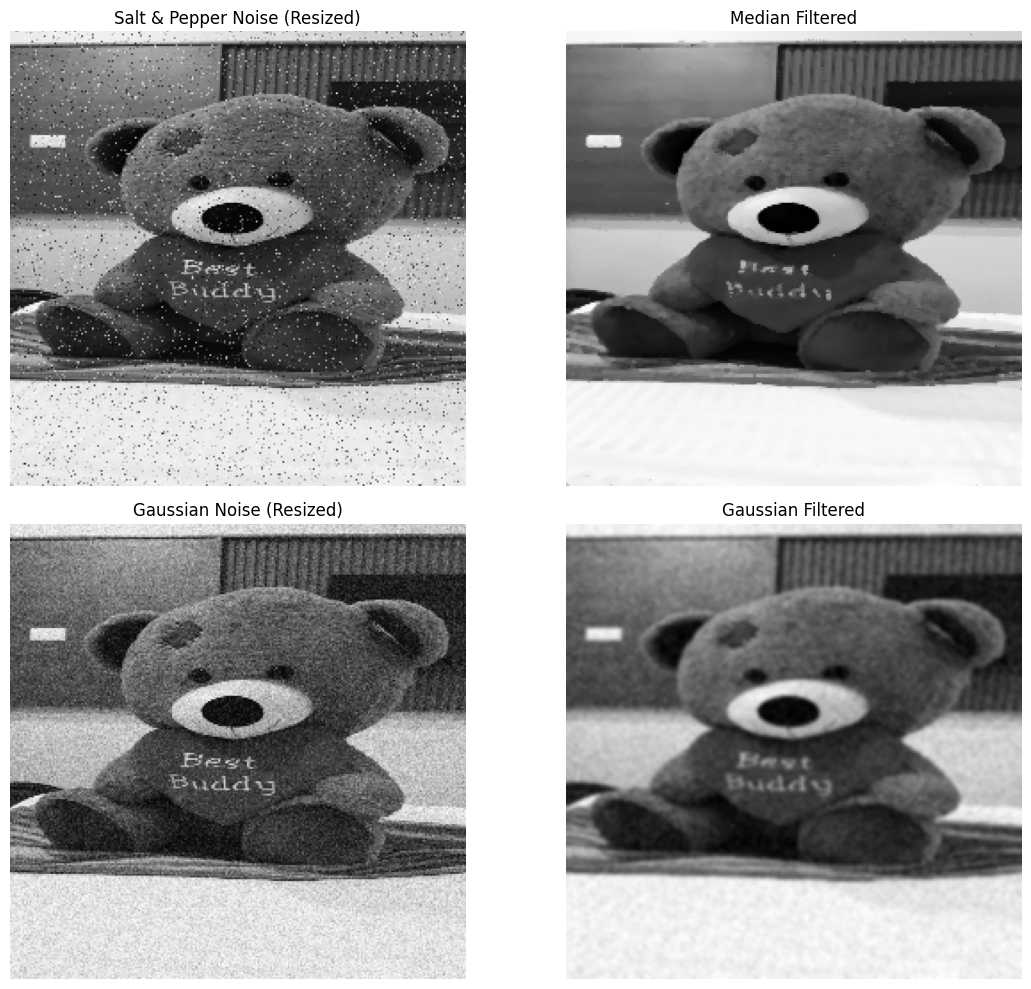

In [20]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# --- Salt & Pepper (Median Filter) ---
# Convert and resize
sp_uint8 = (sp_img * 255).astype(np.uint8)
sp_gray = cv2.cvtColor(sp_uint8, cv2.COLOR_RGB2GRAY)
sp_resized = cv2.resize(sp_gray, (256,256))

# Apply median filter
median_filtered = cv2.medianBlur(sp_resized, 3)

# --- Gaussian (Gaussian Filter) ---
# Convert and resize
gauss_uint8 = (gaussian_img * 255).astype(np.uint8)
gauss_gray = cv2.cvtColor(gauss_uint8, cv2.COLOR_RGB2GRAY)
gauss_resized = cv2.resize(gauss_gray, (256,256))

# Apply Gaussian filter
gaussian_filtered = cv2.GaussianBlur(gauss_resized, (5,5), 0)

# --- Reference (original resized grayscale) ---
original_resized = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (256,256))

# --- Calculate PSNR and SSIM ---
psnr_median = psnr(original_resized, median_filtered)
ssim_median = ssim(original_resized, median_filtered)

psnr_gaussian = psnr(original_resized, gaussian_filtered)
ssim_gaussian = ssim(original_resized, gaussian_filtered)

print("Median Filter - PSNR:", round(psnr_median,2), " SSIM:", round(ssim_median,3))
print("Gaussian Filter - PSNR:", round(psnr_gaussian,2), " SSIM:", round(ssim_gaussian,3))

# --- Show results ---
fig, axs = plt.subplots(2, 2, figsize=(12,10))

axs[0,0].imshow(sp_resized, cmap='gray'); axs[0,0].set_title("Salt & Pepper Noise (Resized)"); axs[0,0].axis("off")
axs[0,1].imshow(median_filtered, cmap='gray'); axs[0,1].set_title("Median Filtered"); axs[0,1].axis("off")

axs[1,0].imshow(gauss_resized, cmap='gray'); axs[1,0].set_title("Gaussian Noise (Resized)"); axs[1,0].axis("off")
axs[1,1].imshow(gaussian_filtered, cmap='gray'); axs[1,1].set_title("Gaussian Filtered"); axs[1,1].axis("off")

plt.tight_layout()
plt.show()


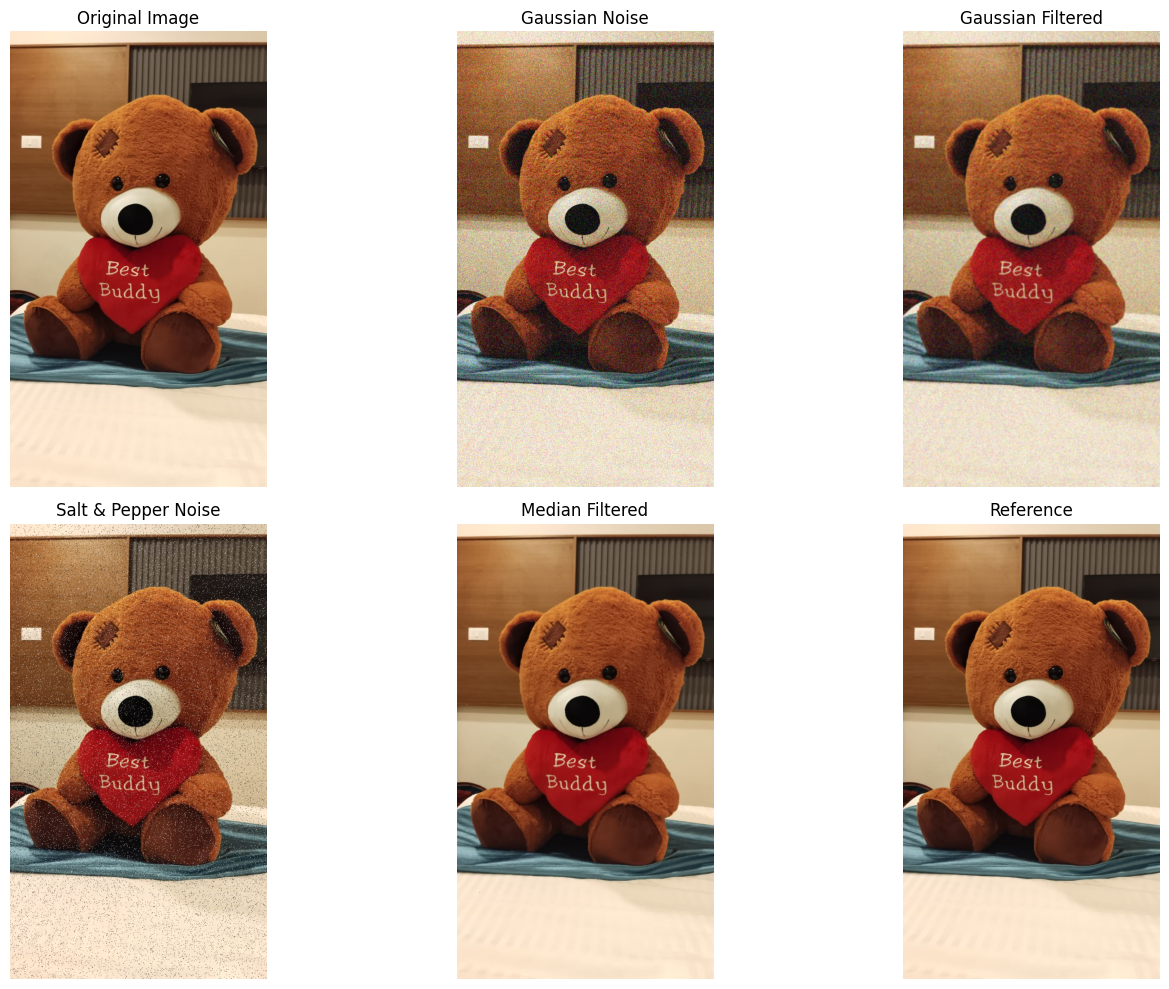

In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# --- Gaussian Noise on Color Image ---
gaussian_noisy_color = (add_gaussian_noise(img_float) * 255).astype(np.uint8)
gaussian_denoised = cv2.GaussianBlur(gaussian_noisy_color, (5,5), 0)

# --- Salt & Pepper Noise on Color Image ---
sp_noisy_color = (add_salt_pepper_noise(img_float) * 255).astype(np.uint8)
median_denoised = cv2.medianBlur(sp_noisy_color, 3)

# --- Show Results ---
fig, axs = plt.subplots(2, 3, figsize=(15,10))

# Original
axs[0,0].imshow(img_rgb)
axs[0,0].set_title("Original Image")
axs[0,0].axis("off")

# Gaussian noisy
axs[0,1].imshow(gaussian_noisy_color)
axs[0,1].set_title("Gaussian Noise")
axs[0,1].axis("off")

# Gaussian filtered
axs[0,2].imshow(gaussian_denoised)
axs[0,2].set_title("Gaussian Filtered")
axs[0,2].axis("off")

# Salt & Pepper noisy
axs[1,0].imshow(sp_noisy_color)
axs[1,0].set_title("Salt & Pepper Noise")
axs[1,0].axis("off")

# Median filtered
axs[1,1].imshow(median_denoised)
axs[1,1].set_title("Median Filtered")
axs[1,1].axis("off")

# Blank (or put original again for reference)
axs[1,2].imshow(img_rgb)
axs[1,2].set_title("Reference")
axs[1,2].axis("off")

plt.tight_layout()
plt.show()


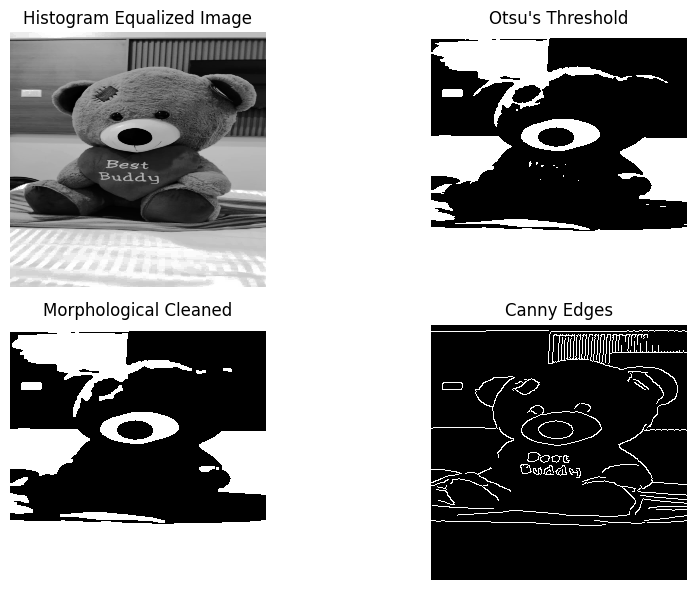

In [5]:
# --- Segmentation and Object Analysis ---

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Use your preprocessed image from previous step
# 'hist_eq' is the histogram-equalized, resized grayscale image

# Step 1: Apply Gaussian blur to reduce small noise before segmentation
blur = cv2.GaussianBlur(hist_eq, (5, 5), 0)

# Step 2: Otsu's Thresholding
ret, otsu_thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Step 3: Morphological operations to clean up small spots
kernel = np.ones((3, 3), np.uint8)
morph = cv2.morphologyEx(otsu_thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Step 4: Canny Edge Detection
edges = cv2.Canny(blur, 100, 200)

# Step 5: Display all results
titles = ['Histogram Equalized Image', "Otsu's Threshold", 'Morphological Cleaned', 'Canny Edges']
images = [hist_eq, otsu_thresh, morph, edges]

plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


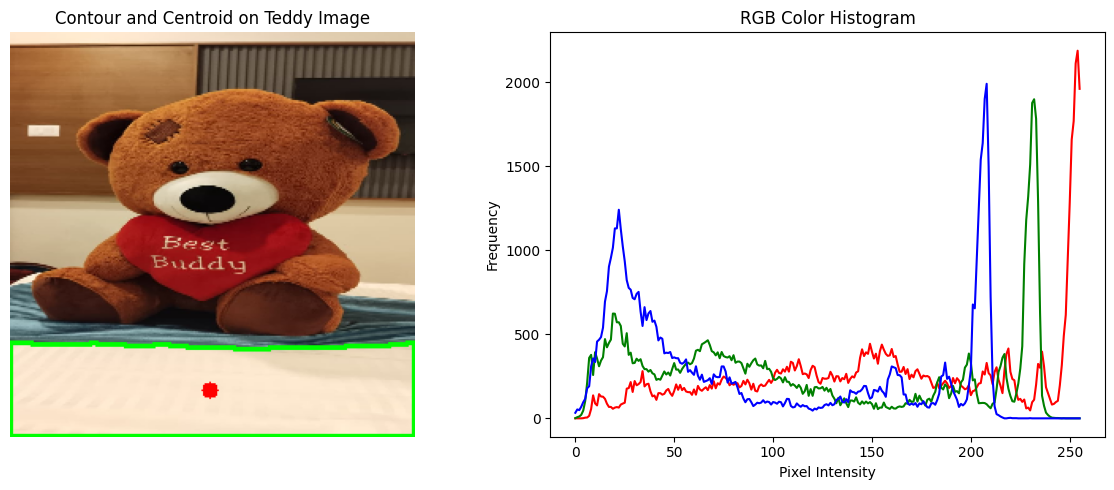

Object Area: 14533.00 pixels
Centroid Location: (126, 226)


In [6]:
# --- Feature Evaluation and Interpretation ---

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the same image (colored version)
img = cv2.imread('teddy.jpg')
img = cv2.resize(img, (256, 256))

# Convert BGR → RGB for displaying correctly
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Step 2: Use your thresholded mask from previous section (Otsu's result)
# If you ran the previous cell, 'morph' contains the cleaned binary mask
mask = morph

# Step 3: Find contours and compute area & centroid
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) > 0:
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    M = cv2.moments(largest_contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0
else:
    area, cx, cy = 0, 0, 0

# Draw contour and centroid
img_contour = rgb_img.copy()
cv2.drawContours(img_contour, [largest_contour], -1, (0, 255, 0), 2)
cv2.circle(img_contour, (cx, cy), 5, (255, 0, 0), -1)

# Step 4: Plot RGB histograms
colors = ('r', 'g', 'b')
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_contour)
plt.title("Contour and Centroid on Teddy Image")
plt.axis('off')

plt.subplot(1, 2, 2)
for i, col in enumerate(colors):
    hist = cv2.calcHist([rgb_img], [i], None, [256], [0, 256])
    plt.plot(hist, color=col)
plt.title("RGB Color Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Step 5: Print results
print(f"Object Area: {area:.2f} pixels")
print(f"Centroid Location: ({cx}, {cy})")


In [8]:
# --- PSNR & SSIM Evaluation for Filters (Table I) ---

import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Step 1: Read and resize the image
img = cv2.imread('teddy.jpg')
img = cv2.resize(img, (256, 256))

# Step 2: Add noise (Gaussian and Salt & Pepper)
gaussian_noise = np.random.normal(0, 20, img.shape).astype(np.float32)
noisy_gaussian = cv2.add(img.astype(np.float32), gaussian_noise)
noisy_gaussian = np.clip(noisy_gaussian, 0, 255).astype(np.uint8)

# Step 3: Apply Median and Gaussian filters
median_filtered = cv2.medianBlur(noisy_gaussian, 3)
gaussian_filtered = cv2.GaussianBlur(noisy_gaussian, (5, 5), 0)

# Step 4: Calculate PSNR and SSIM between original & filtered images
psnr_median = psnr(img, median_filtered)
ssim_median = ssim(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                   cv2.cvtColor(median_filtered, cv2.COLOR_BGR2GRAY))

psnr_gaussian = psnr(img, gaussian_filtered)
ssim_gaussian = ssim(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                     cv2.cvtColor(gaussian_filtered, cv2.COLOR_BGR2GRAY))

# Step 5: Print comparison table
print("\nTable I: Comparison of Filter Performance")
print("-------------------------------------------")
print(f"{'Filter Type':<20} {'PSNR (dB)':<15} {'SSIM':<10}")
print("-------------------------------------------")
print(f"{'Median Filter':<20} {psnr_median:<15.2f} {ssim_median:<10.3f}")
print(f"{'Gaussian Filter':<20} {psnr_gaussian:<15.2f} {ssim_gaussian:<10.3f}")



Table I: Comparison of Filter Performance
-------------------------------------------
Filter Type          PSNR (dB)       SSIM      
-------------------------------------------
Median Filter        26.36           0.755     
Gaussian Filter      26.64           0.813     
